In [33]:
#from google.colab import drive
#drive.mount('/content/drive')

In [34]:
TRANSACTION_DATA_FILE_PATH = 'data' #'drive/MyDrive/data_torrado'

In [35]:
%pip install langgraph langchain-ollama

Note: you may need to restart the kernel to use updated packages.


In [36]:
#General inputs
import pandas as pd

import difflib
import duckdb

from typing_extensions import TypedDict, Optional, NotRequired

In [37]:
#graph imports
from langgraph.graph import END, StateGraph

from functools import partial
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

In [38]:
#llama setup
from langchain_ollama import ChatOllama
llm = ChatOllama(model="llama3.2", temperature=0.1, max_tokens=2000, streaming=True)

In [39]:
# Check LLM is working
response = llm.invoke("Tell me about the LangChain framework.")
print(response)

content='LangChain is an open-source, Python-based framework for building blockchain-agnostic data pipelines and workflows. It was created by Alex Bradley and is designed to simplify the process of integrating blockchain technology with external systems.\n\nKey Features:\n\n1. **Modular Architecture**: LangChain provides a modular architecture that allows developers to build custom workflows using a variety of components, including data sources, processing functions, and storage solutions.\n2. **Blockchain-Agnostic**: LangChain is designed to work with multiple blockchain platforms, including Ethereum, Solana, and Polkadot, among others. This means that developers can focus on building their workflow without worrying about the underlying blockchain technology.\n3. **Data Pipelines**: LangChain provides a robust data pipeline system that allows developers to manage data flow between different components of their workflow. This includes features like data transformation, filtering, and a

In [40]:
class State (TypedDict):
    prompt: str
    data: str
    analyze_data : str
    answer: str
    visualization_goal: Optional[str]  # Para almacenar el objetivo de visualización
    chart_config: Optional[dict]  # Para almacenar la configuración del gráfico
    tool_choice: NotRequired[str]

In [41]:
def decide_tool(state: State, llm) -> State:
    tools_description = """" " \
    You have access to the following tools to help you with your task:

    - lookup_sales_data: This tool allows you to look up sales data from a parquet file using SQL queries. Use it to retrieve specific sales data based on your prompt.
    - analyzing_data: This tool allows you to analyze the sales data. Use it to extract insights or trends from the data. Use it to answer questions about the data, like trends, correlations, or other insights. Obviously, this tool should be used after the lookup_sales_data tool.
    - create_visualization: This tool allows you to create visualizations based on the sales data. Use it to generate charts or graphs that represent the data visually. Use it when the user may ask for a chart or graph of the data, obviously preceded from other tools like analyzing_data or lookup_sales_data.
    - end: This tool allows you to end the conversation. Use it when the user is satisfied with the information provided and no further action is needed. For example, if you already did the chart graph and the user's prompt will be satisfied

    Based on the actual state and the user prompt, decide which tool to use next.
    """

    decision_prompt = f"""
    {tools_description}
    Current state:
    - Prompt: {state['prompt']}
    - Answer so far: {state.get('answer', [])}
    - Visualization goal: {state.get('visualization_goal')}
    - Tool used last: {state.get('tool_choice')}
    Based on the current state and the user prompt, decide which tool to use next. Choose just between the three tools: lookup_sales_data, analyzing_data, or create_visualization.
    In this case, please just minimize the answer to the name of the tool you choose.
    Keep in mind:
    - Do NOT use a tool that was already used earlier in the conversation.
    - If analysis and visualization are both completed, respond with "end".
    - If you already used the tools relevant for the prompt, stop by choosing "end".
    """
    #print("Este es el state a la hora de decidir la herramienta: "+str(state.keys()))
    try:
        current_prompt = state["prompt"]
        current_answer = state.get("answer", [])
        visualization_goal = state.get("visualization_goal")
        chart_config = state.get("chart_config")
        analyzed_data = state.get("analyze_data")
        response = llm.invoke(decision_prompt)
        #print("Esta es la decision"+str(response))
        tool_choice = response.content.strip().lower()
        #print(f"que printea la choice:{tool_choice}")
        # Verificar si la elección de herramienta es válida
        valid_tools = ["lookup_sales_data", "analyzing_data", "create_visualization", "end"]
        matched_tool = None

        closest_match = difflib.get_close_matches(tool_choice, valid_tools, n=1, cutoff=0.6)
        matched_tool = closest_match[0] if closest_match else "lookup_sales_data"

        if matched_tool in ["analyzing_data", "create_visualization"] and state.get("data") is None:
            matched_tool = "lookup_sales_data"
        else:
            if len(state.get("answer", [])) > 1:
                matched_tool = "end"


        print(f"Elección de herramienta: {matched_tool}")

        # Crea un nuevo estado para evitar la mutación directa
        return {
            **state,  # Mantiene TODO el estado original
            "prompt": current_prompt,  # Reforzamos estas claves
            "answer": current_answer,
            "analyze_data": analyzed_data,
            "visualization_goal": visualization_goal,
            "chart_config": chart_config,
            "tool_choice": matched_tool  # Actualiza solo esta
            }
    except Exception as e:
        return {**state, "error": f"Error accessing data: {str(e)}"}

In [ ]:
SQL_Generation_Prompt = "" \
"Generate an SQL query based on the prompt. Please just reply with the SQL query and NO MORE, just the query. Really there is no need to create any comment besides the query, that's the only important thing. The prompt is : {prompt}" \
"The available columns are: {columns}. " \
"The table name is: {table_name}. " \
"⚠️ If you need to use a DATE column with LIKE or pattern matching, first CAST it to VARCHAR like this: CAST(date_column AS VARCHAR) LIKE '%2021-11%' " \
"Return only the SQL query, with no explanations or markdown formatting."

def generate_sql_query (state:State, columns: list, table_name: str):
    # Formateamos el prompt para generar la consulta SQL
    formatted_prompt = SQL_Generation_Prompt.format(prompt=state["prompt"], columns=columns, table_name=table_name)


    # Aquí invocamos LLaMA para generar la consulta SQL
    sql_query = llm.invoke(formatted_prompt)
    # Retornamos el nuevo estado con la respuesta
    try:
        sql_query = sql_query.content
        sql_query = sql_query.strip()
        sql_query = sql_query.replace("```sql", "").replace("```", "")
        #print("Esta es la query en el return"+sql_query)
        return sql_query
    except Exception as e:
        return {**state, "error": f"Error accessing data: {str(e)}"}

def lookup_sales_data(state:State):
    """Implementation of sales data lookup from parquet file using SQL"""
    try:

        # define the table name
        table_name = "sales"

        # step 1: read the parquet file into a DuckDB table
        df = pd.read_parquet(TRANSACTION_DATA_FILE_PATH)
        duckdb.sql(f"CREATE TABLE IF NOT EXISTS {table_name} AS SELECT * FROM df")
        # step 2: generate the SQL code
        sql_query = generate_sql_query(state, df.columns, table_name)
        # clean the response to make sure it only includes the SQL code


        # step 3: execute the SQL query
        result = duckdb.sql(sql_query).df()
        result = result.to_string()

        #print("Resultado de lookup_sales_data:", result)
        return {**state, "data": result}
    except Exception as e:
        return {**state, "error": f"Error accessing data: {str(e)}"}

In [43]:
DATA_ANALYSIS_PROMPT = """
Analyze the following data: {data}
Your job is to answer the following question: {prompt}
"""
def analyzing_data(state: State) -> State:
    try:
        #pprint.pprint("llegue al analisis y estas son sus llaves "+str(state.keys()))
        formatted_prompt = DATA_ANALYSIS_PROMPT.format(data=state["data"], prompt=state["prompt"])
        analysis_result = llm.invoke(formatted_prompt)
        analysis_result = analysis_result.content
        return {**state, "analyze_data": analysis_result, "answer": state.get("answer", []) + [analysis_result],         "visualization_goal": state.get("visualization_goal"),
        "chart_config": state.get("chart_config")}
    except Exception as e:
        return {**state, "error": f"Error accessing data: {str(e)}"}

In [44]:
CHART_CONFIGURATION_PROMPT = """
Generate a chart configuration based on this data: {data}
The goal is to show: {visualization_goal}
"""

def extract_chart_config(state:State) -> State:
        # Verificar si ya tenemos datos para visualizar
    if "data" not in state or state["data"] is None or state["data"]=="":
        return {**state, "chart_config": None}
    # Verificar si ya tenemos un objetivo de visualización
    # Verificar explícitamente si existe "visualization_goal" en el estado
    if "visualization_goal" in state:
        visualization_goal = state["visualization_goal"]
    else:
        visualization_goal = state["prompt"]
    formatted_prompt = CHART_CONFIGURATION_PROMPT.format(
            data=state["data"],
            #data = data,
            visualization_goal=visualization_goal
    )
    #print("Este es el estado a la hora de extraer la configuracion del chart: "+str(state.keys()))
    response = llm.invoke(formatted_prompt)
    try:
        # Extract axis and title info from response
        content = response.content

        # Return structured chart config
        chart_config={
        "chart_type": content.chart_type,
        "x_axis": content.x_axis,
        "y_axis": content.y_axis,
        "title": content.title,
        "data": state["data"]}
        print("Este es el chart config: "+str(chart_config))
        return{**state, "chart_config": chart_config,
        "visualization_goal": state.get("visualization_goal"),
        "chart_config": state.get("chart_config"),
        "analyze_data": state.get("analyze_data")}
    except Exception:
        chart_config={"chart_type": "line",
        "x_axis": "date",
        "y_axis": "value",
        "title": visualization_goal,
        "data": state["data"]}
        return {**state, "chart_config": chart_config,
        "visualization_goal": state.get("visualization_goal"),
        "chart_config": state.get("chart_config"),
        "analyze_data": state.get("analyze_data")}


CREATE_CHART_PROMPT = """
Write python code to create a chart based on the following configuration.
Only return the code, no other text.
config: {config}
"""

def create_chart(state: State):
    try:
        formatted_prompt = CREATE_CHART_PROMPT.format(config=state["chart_config"])
        response = llm.invoke(formatted_prompt)
        code = response.content
        code = code.replace("```python", "").replace("```", "")
        #print("Este es el estado en la creacion del chart: "+str(state.keys()))
        # Clean the code and remove any unwanted characters
        return code
    except Exception as e:
        print("Error creating chart: ", e)
        return {**state, "error": f"Error accessing data: {str(e)}"}


def create_visualization(state: State) -> State:
    try:
        config = extract_chart_config(state)
        code = create_chart(config)

        return {**state, "config": config["chart_config"],
        "visualization_goal": config.get("visualization_goal"),
        "chart_config": config.get("chart_config"),
        "analyze_data": state.get("analyze_data"), "answer": state.get("answer", []) + [code]}
    except Exception as e:
            return {**state, "error": f"Error accessing data: {str(e)}"}


In [45]:
def route_to_tool(state: State):
    tool_choice = state.get("tool_choice", "lookup_sales_data")
    valid_tools = ["lookup_sales_data", "analyzing_data", "create_visualization", "end"]
    # Check if the tool choice is valid
    return tool_choice if tool_choice in valid_tools else "end"

In [46]:
graph = StateGraph(State)
decide_tool_with_llm = partial(decide_tool, llm=llm)
graph.add_node("decide_tool", decide_tool_with_llm)

graph.add_node("lookup_sales_data", lookup_sales_data)
graph.add_node("analyzing_data", analyzing_data)
graph.add_node("create_visualization", create_visualization)
graph.set_entry_point("decide_tool")

graph.add_conditional_edges(
    "decide_tool",
    route_to_tool,
    {
        "lookup_sales_data": "lookup_sales_data", #dictionaries are needed as the conditional must have the name of the return value of the function which routes to the next node
        "analyzing_data": "analyzing_data",
        "create_visualization": "create_visualization",
        "end": END,
    }
)

graph.add_edge("lookup_sales_data", "decide_tool")
graph.add_edge("analyzing_data", "decide_tool")
graph.add_edge("create_visualization", "decide_tool")

graph = graph.compile()

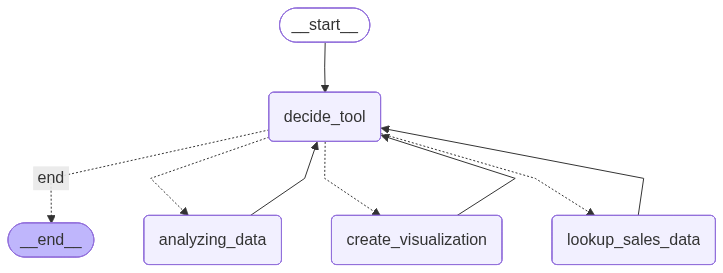

In [47]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # Fallback se mermaid non è disponibile
    print(graph.get_graph().print_ascii())

In [48]:
input_state = {"prompt": "Show me the sales in Nov 2021"}
result = graph.invoke(input_state)

Elección de herramienta: lookup_sales_data
Elección de herramienta: lookup_sales_data
Elección de herramienta: analyzing_data
Elección de herramienta: create_visualization
Elección de herramienta: end


In [51]:
result

{'prompt': 'Show me the sales in Nov 2021',
 'data': '       Total_Sale_Value\n0             56.849998\n1             18.950001\n2             18.950001\n3             18.950001\n4             18.950001\n5             18.950001\n6             37.900002\n7             18.950001\n8             18.950001\n9             18.950001\n10            18.950001\n11            18.950001\n12            12.510000\n13            18.950001\n14            37.900002\n15            18.950001\n16            37.900002\n17            18.950001\n18            19.990000\n19            19.990000\n20            19.990000\n21            19.990000\n22            19.990000\n23            19.990000\n24            19.990000\n25            19.990000\n26            39.980000\n27            19.990000\n28            39.900002\n29            79.959999\n30            19.990000\n31            19.990000\n32             7.990000\n33            23.969999\n34             7.990000\n35             7.990000\n36            15.9800

In [49]:
import matplotlib.pyplot as plt

# Assuming data is already available in config
def plot_chart(config):
    if config is None:
        print("No data provided")
        return

    # Extract relevant data from config
    labels = [label for label in config.keys()]
    values = [config[label] for label in labels]

    # Create the chart
    plt.bar(labels, values)
    plt.xlabel('Labels')
    plt.ylabel('Values')
    plt.title('Chart Title')
    plt.show()

# Example usage:
# plot_chart(config)  # Replace with your actual config data